In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
import json
from custom_preprocessor import preprocess

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [22]:
df = pd.read_csv('./data/dataset_families.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language Family
164966,a et uvilkarlig,Germanic
448121,sentahden pidankin sentahden,Uralic
442087,ja harrastuksella nuorukaiset,Uralic
457539,ennenkuin luoti lensi,Uralic
416958,ajtostol,Uralic


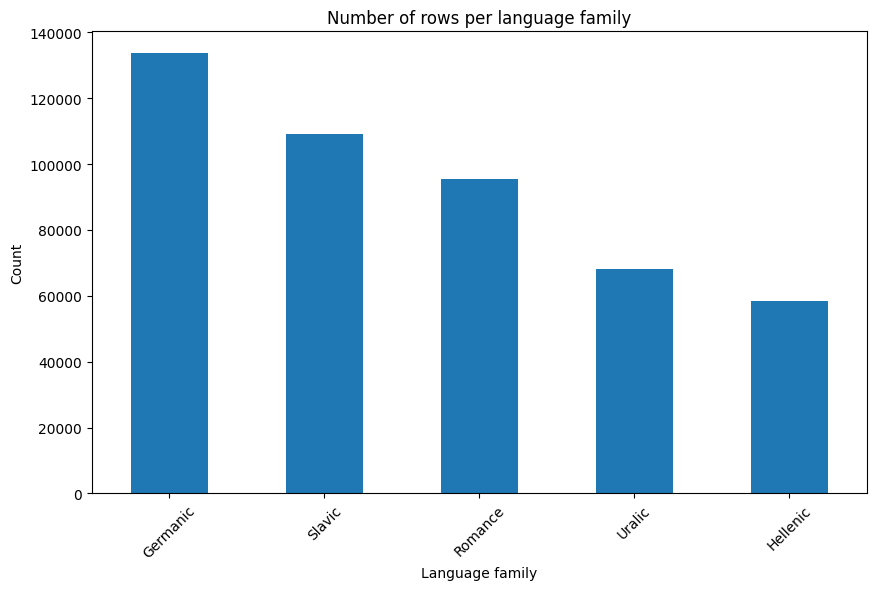

In [23]:
category_counts = df.iloc[:, -1].value_counts()
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Number of rows per language family')
plt.xlabel('Language family')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [24]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
print(input_dim)
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of language families to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

40
Rows: 464833
Amount of language families to identify: 5


In [25]:
model = Sequential()
model.add(Conv1D(input_dim, 2, activation='relu'))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [26]:
history = model.fit(X_train.astype('float32'), y_train.astype('float32'), validation_data=(X_val, y_val), epochs=40, batch_size=2048,verbose=1)

Epoch 1/40
182/182 [==============================] - 34s 181ms/step - loss: 1.4223 - accuracy: 0.3931 - val_loss: 1.2660 - val_accuracy: 0.4824
Epoch 2/40
182/182 [==============================] - 33s 184ms/step - loss: 1.1881 - accuracy: 0.5192 - val_loss: 1.0654 - val_accuracy: 0.5802
Epoch 3/40
182/182 [==============================] - 34s 187ms/step - loss: 1.0326 - accuracy: 0.5988 - val_loss: 0.9290 - val_accuracy: 0.6430
Epoch 4/40
182/182 [==============================] - 33s 183ms/step - loss: 0.8774 - accuracy: 0.6694 - val_loss: 0.7848 - val_accuracy: 0.7077
Epoch 5/40
182/182 [==============================] - 35s 190ms/step - loss: 0.7590 - accuracy: 0.7194 - val_loss: 0.6704 - val_accuracy: 0.7556
Epoch 6/40
182/182 [==============================] - 35s 192ms/step - loss: 0.6830 - accuracy: 0.7507 - val_loss: 0.6250 - val_accuracy: 0.7724
Epoch 7/40
182/182 [==============================] - 35s 192ms/step - loss: 0.6236 - accuracy: 0.7754 - val_loss: 0.5803 - val_ac

KeyboardInterrupt: 

# Loss evaluation

Seeing how the model's loss changes by the epoch

In [ ]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Loss evaluation

Seeing how the model's loss changes by the epoch

In [ ]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [ ]:
prediction_word = ("Привет!")
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}%")

# Save model
Here a model can be loaded

In [ ]:
model.save('./models/model_families.keras')
tokenizer_json = tokenizer.to_json()
with open('./tokenizer_configs/tokenizer_config_families.json', 'w') as config_file:
    config_file.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Load model
Here a model can be loaded

In [ ]:
model = load_model('./models/model_families.keras')